In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")

In [2]:
data = pd.read_csv('train.csv')
df = data.copy()
data_r = pd.read_csv('Riders.csv')
df_r = data_r.copy()
df_merged = pd.merge(df, df_r, how='inner', on='Rider Id')

# Exploratory Data Analysis

In [3]:
df_merged.shape

(21201, 33)

<AxesSubplot:>

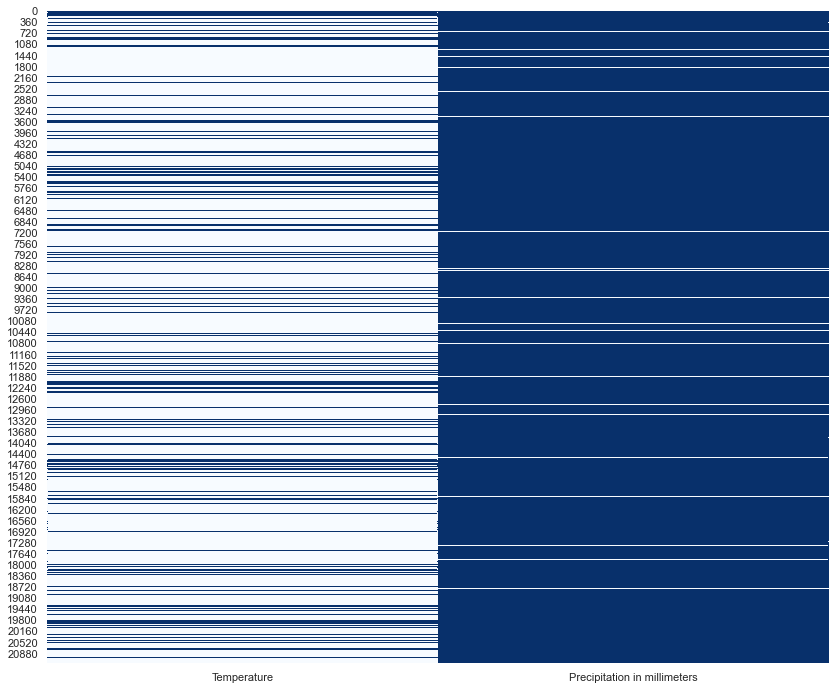

In [4]:
plt.figure(figsize = (14,12))
sns.heatmap(df_merged[['Temperature','Precipitation in millimeters']].isna(), cmap = 'Blues', cbar = False)

La majorité des données sur les precipitations sont vides. C'est moins flagrant pour la temperature.

In [5]:
((df_merged['Temperature'].isna().sum())/(df_merged['Temperature'].shape[0])) * 100

20.593368237347295

## Analyse de fond

### Visualisation de la target

In [6]:
df_merged['Time from Pickup to Arrival'].describe()

count    21201.000000
mean      1556.920947
std        987.270788
min          1.000000
25%        882.000000
50%       1369.000000
75%       2040.000000
max       7883.000000
Name: Time from Pickup to Arrival, dtype: float64

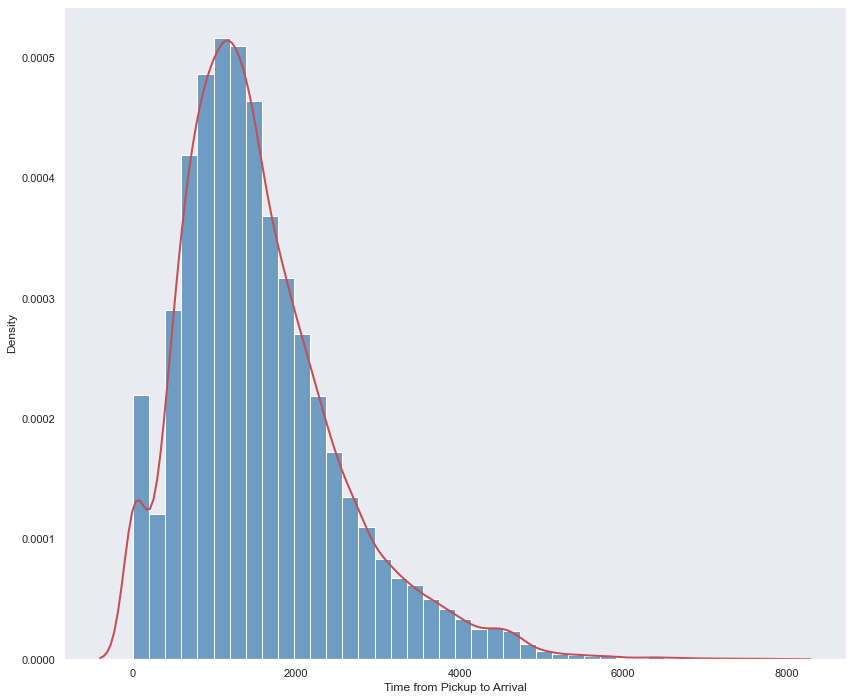

In [7]:
plt.figure(figsize = (14,12))
sns.histplot(x=df_merged['Time from Pickup to Arrival'], color='steelblue', bins = 40, stat='density')
sns.kdeplot(x=df_merged['Time from Pickup to Arrival'], color='r', linewidth=2)
plt.xlabel('Time from Pickup to Arrival')
plt.ylabel('Density')
plt.show()

Séparation en variables numériques et catégorielles

In [8]:
numerical_col = df_merged.select_dtypes(include=['int64','float']).columns

categorical_col = df_merged.select_dtypes(exclude=['int64','float']).columns

time_col = ['Pickup - Time', 'Arrival at Pickup - Time', 'Placement - Time',
        'Confirmation - Time', 'Arrival at Destination - Time']
categorical_col = categorical_col.drop(['Order No','User Id', 'Rider Id'])
categorical_col = categorical_col.drop(time_col)
numerical_col = numerical_col.tolist()
categorical_col = categorical_col.tolist()

colToswitch = ['Platform Type',
                'Placement - Weekday (Mo = 1)',
                'Arrival at Pickup - Weekday (Mo = 1)',
               'Confirmation - Weekday (Mo = 1)',
               'Pickup - Weekday (Mo = 1)',
               'Arrival at Destination - Weekday (Mo = 1)',
               ]
categorical_col.extend(colToswitch)
for col in colToswitch:
    numerical_col.remove(col)
numerical_col.remove('Time from Pickup to Arrival')

#### Visualisation et analyse des variables numériques

Pour les variables numériques :
    <ul>
    <li> Toutes les variables "Day of Month" sont identiquements distribuées, il semble y avoir des pics le weekend </li>
    <li> Age à subi une transformation numérique </li>
    <li> Toutes les notes sont comprises entre 12 et 16 et certaines sont = 0 (erreur ?) </li>
    <li> La grande majoritée des distances de livraison est entre 0 et 20 km </li>
    <li> Les températures sont entre 0 et 30 degrés </li>
    </ul>

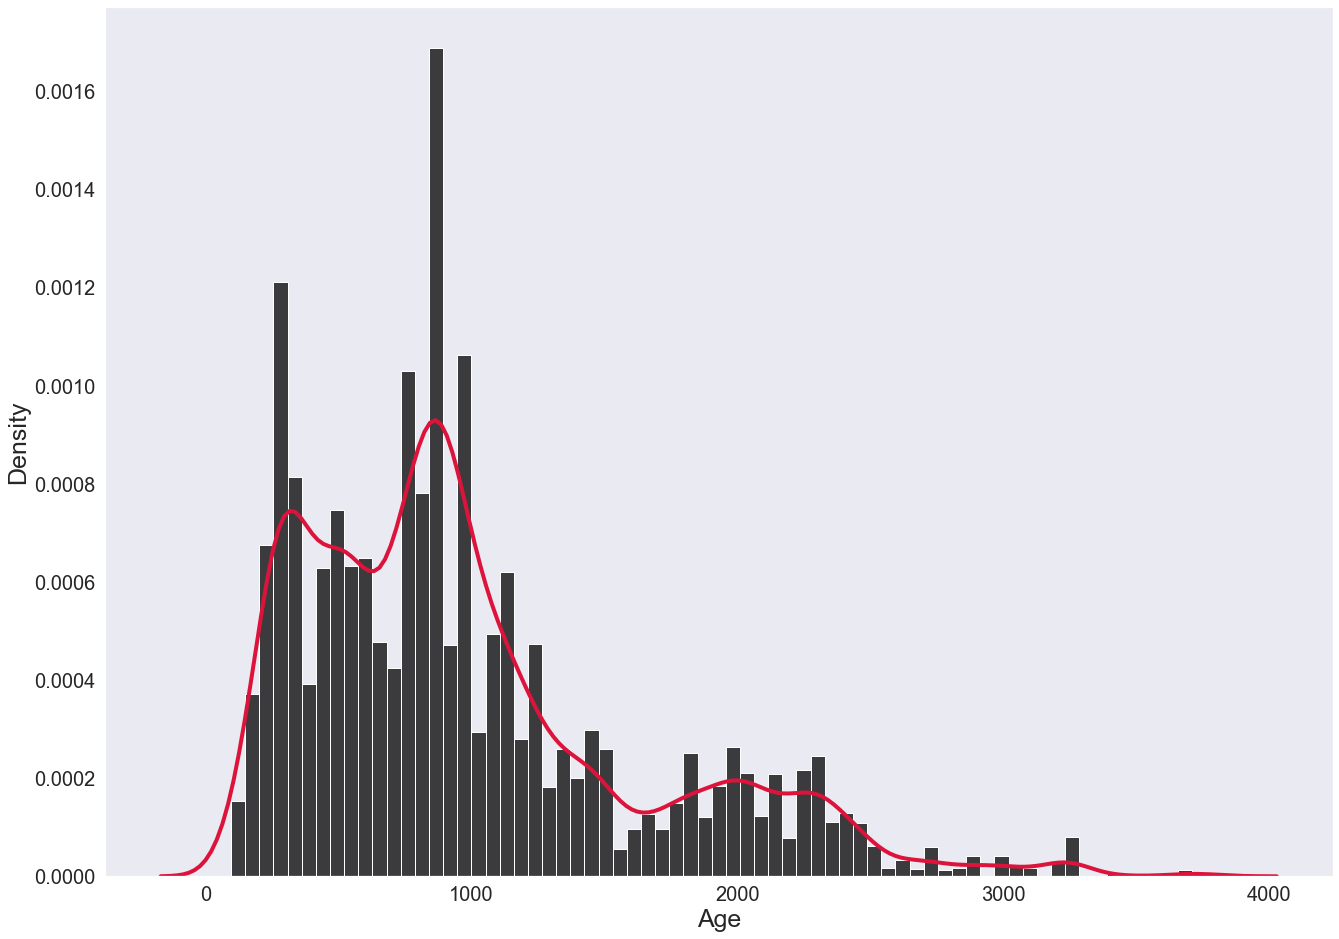

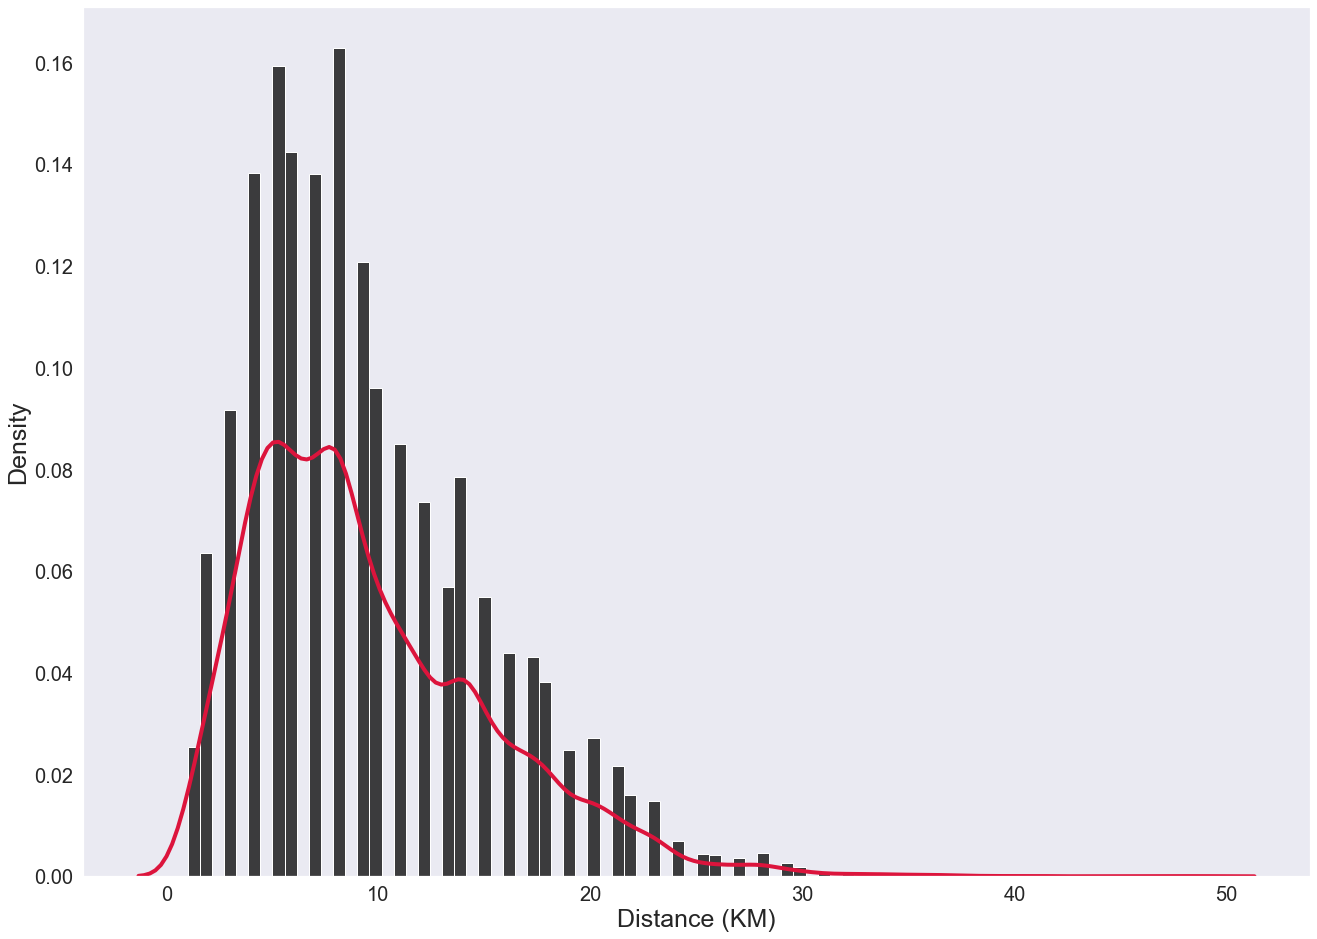

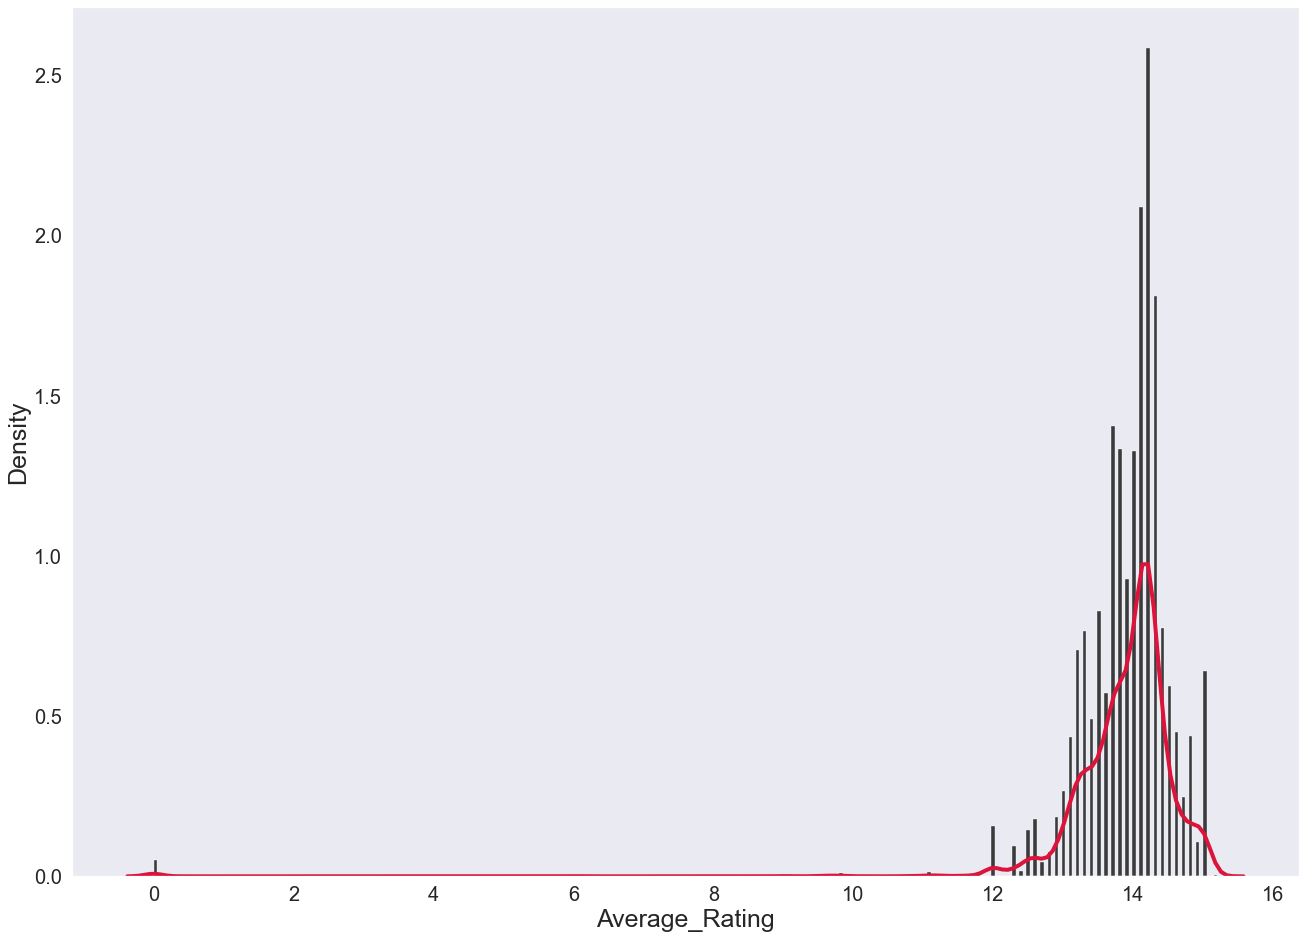

In [9]:
for colonne in ['Age', 'Distance (KM)', 'Average_Rating']:
    plt.figure(figsize = (22,16))
    sns.histplot(x=df_merged[colonne], color='black', stat='density')
    sns.kdeplot(x=df_merged[colonne], color='crimson', linewidth=4)
    plt.xlabel(colonne, fontsize = 25)
    plt.ylabel('Density', fontsize = 25)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.show()

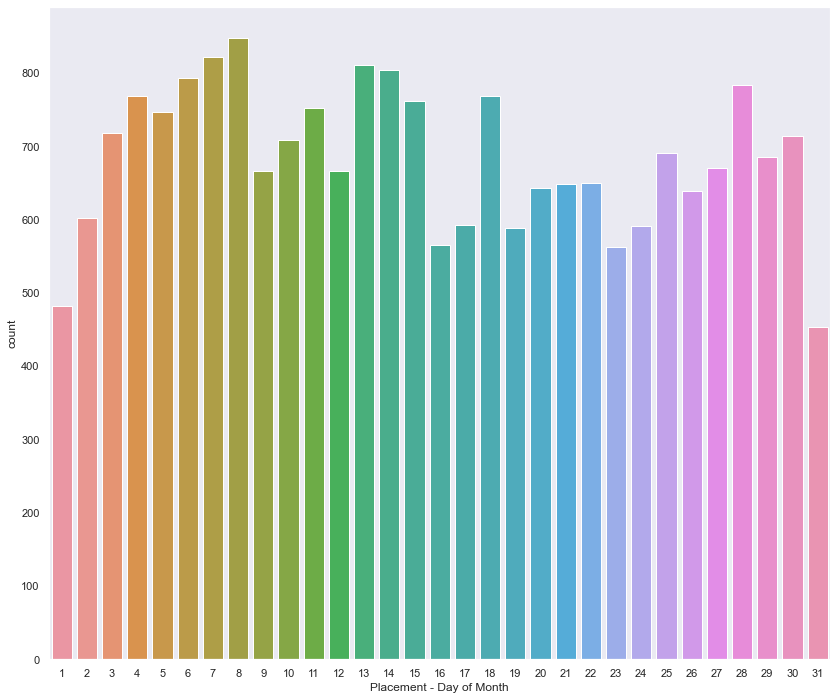

In [10]:
plt.figure(figsize = (14,12))
sns.countplot(x = 'Placement - Day of Month', data=df_merged)
plt.show()

#### Visualisation et analyse des variables qualitatives

In [11]:
def transfo_jour(x):
    if x == 1:
        x = str('Monday')
    elif x == 2:
        x = str('Tuesday')
    elif x == 3:
        x = str('Wednesday')
    elif x == 4:
        x = str('Thursday')
    elif x == 5:
        x = str('Friday')
    elif x == 6:
        x = str('Saturday')
    else:
        x = str('Sunday')
    return x

In [12]:
import re
for col in categorical_col:
    if(re.search('Weekday',col)) != None:
       df_merged[col] = df_merged[col].apply(transfo_jour)

In [13]:
for col in df[categorical_col]:
    print(f'{col :-<50} {df_merged[col].unique()}')

Vehicle Type-------------------------------------- ['Bike']
Personal or Business------------------------------ ['Business' 'Personal']
Platform Type------------------------------------- [3 2 1 4]
Placement - Weekday (Mo = 1)---------------------- ['Friday' 'Tuesday' 'Wednesday' 'Monday' 'Thursday' 'Saturday' 'Sunday']
Arrival at Pickup - Weekday (Mo = 1)-------------- ['Friday' 'Tuesday' 'Wednesday' 'Monday' 'Thursday' 'Saturday' 'Sunday']
Confirmation - Weekday (Mo = 1)------------------- ['Friday' 'Tuesday' 'Wednesday' 'Monday' 'Thursday' 'Saturday' 'Sunday']
Pickup - Weekday (Mo = 1)------------------------- ['Friday' 'Tuesday' 'Wednesday' 'Monday' 'Thursday' 'Saturday' 'Sunday']
Arrival at Destination - Weekday (Mo = 1)--------- ['Friday' 'Tuesday' 'Wednesday' 'Monday' 'Thursday' 'Saturday' 'Sunday']


Pour les variables Quantitatives :
    <ul>
    <li> La variable Vehicle Type est inutile car ne comprend qu'une classe </li>
    <li> Il y'a beaucoup plus de clients Buisness que Personal </li>
    <li> Toutes les variables Weekday sont equidistribuées et il semble y'avoir moins de commande le weekend (?)</li>
    <li> La 3e plateforme est la plus utilisée </li>
    </ul>

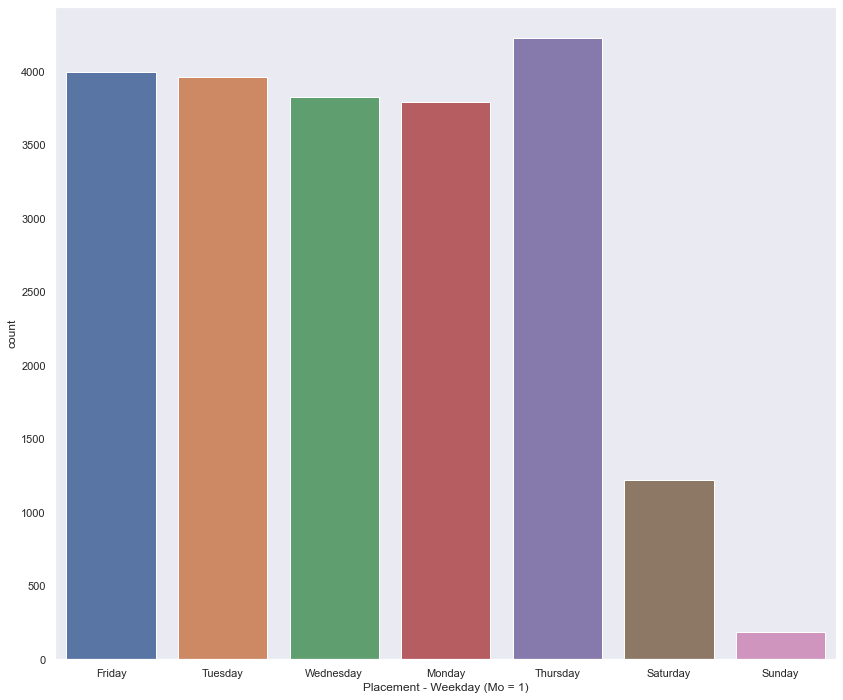

In [14]:
for col in ['Placement - Weekday (Mo = 1)']:
    plt.figure(figsize = (14,12))
    sns.countplot(x = col, data=df_merged)
    plt.show()

#### Visualisation et analyse des variables de temps

In [15]:
def time_processing(x):
    if isinstance(x, int):
        return x
    else:
        if(x[-2:] == 'AM'):
            varadd = 0
        else:
            varadd = 12
        h, m, s = x[:-3].split(':')
        h = int(h)+varadd
        x = h
        return x

In [16]:
for col in time_col:
    df_merged[col] = df_merged[col].apply(time_processing)

La distribution des variables de temps est sensiblement la même

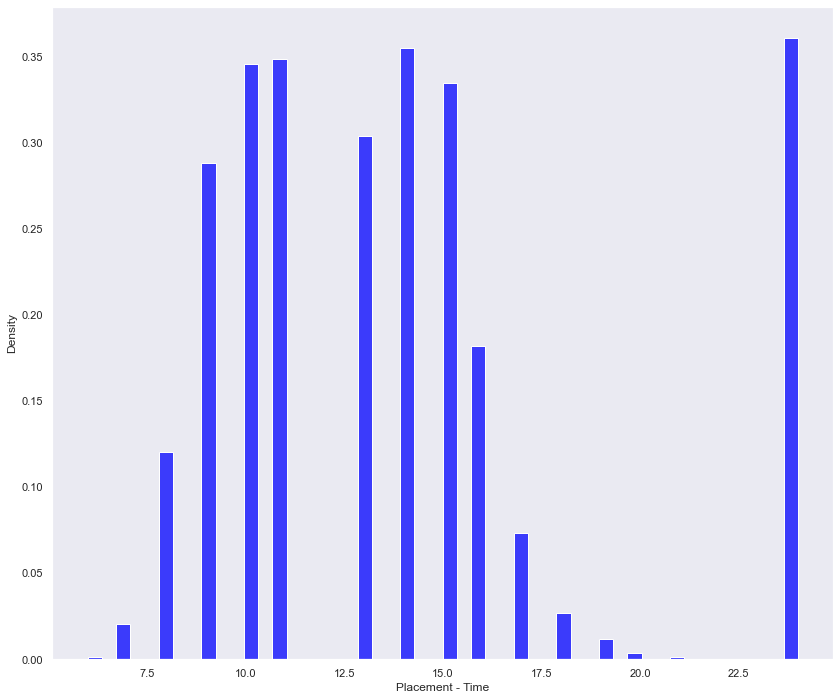

In [17]:
plt.figure(figsize = (14,12))
sns.histplot(x=df_merged['Placement - Time'], color='blue', stat='density')
plt.show()

On peut créer des catégories comme ceci

In [18]:
time_cat = list()
for index in range(df_merged['Placement - Time'].shape[0]):
    if df_merged['Placement - Time'][index] <= 11:
        time_cat.append("Matin")
    elif df_merged['Placement - Time'][index] > 11 and df_merged['Placement - Time'][index] < 17:
        time_cat.append("Apm")
    elif df_merged['Placement - Time'][index] >= 17 and df_merged['Placement - Time'][index] <= 22:
        time_cat.append("Soiree")
    elif df_merged['Placement - Time'][index] > 22:
        time_cat.append("Nuit")

In [19]:
df_merged['Time cat'] = time_cat

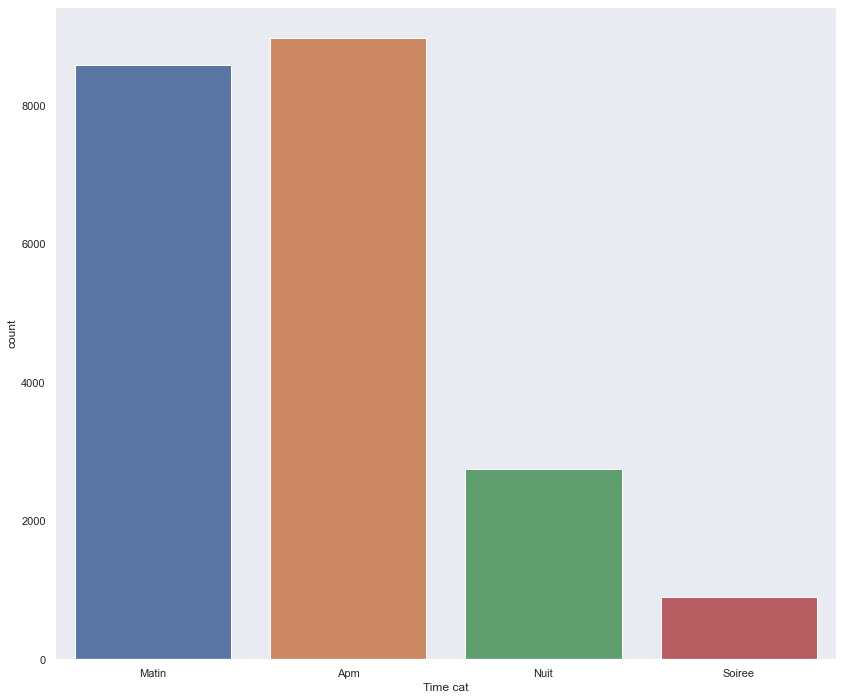

In [20]:
plt.figure(figsize = (14,12))
sns.countplot(x = df_merged['Time cat'])
plt.show()

#### Outliers sur la target

In [21]:
compteur = 0
Q1 = df['Time from Pickup to Arrival'].quantile(0.25)
Q3 = df['Time from Pickup to Arrival'].quantile(0.75)
IQR = Q3 - Q1
for i in range(df['Time from Pickup to Arrival'].shape[0]):
    if(df['Time from Pickup to Arrival'][i] > Q3 + 1.5*IQR):
        compteur+=1
print("Il y'a", str(compteur),"outliers", 
      "soit","{:.2f}".format(compteur/df['Time from Pickup to Arrival'].shape[0]*100) ,'% des données')

Il y'a 775 outliers soit 3.66 % des données


### Relation Variables / Target

#### Relation Target / Variables quanittatives

<AxesSubplot:xlabel='Distance (KM)', ylabel='Time from Pickup to Arrival'>

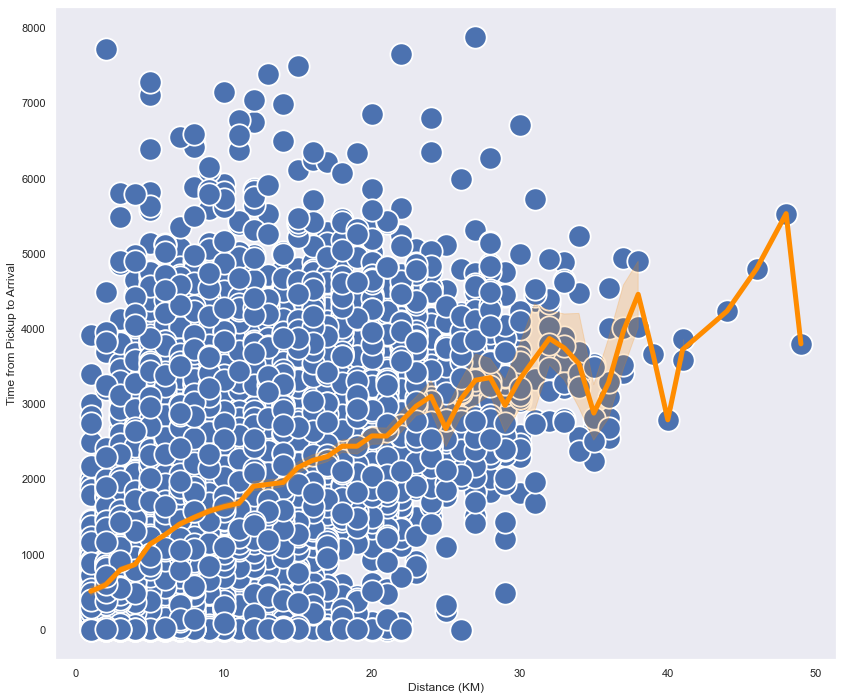

In [22]:
plt.figure(figsize = (14,12))
sns.scatterplot(data=df_merged, x='Distance (KM)', y="Time from Pickup to Arrival", s = 500)
sns.lineplot(data=df_merged, x='Distance (KM)', y="Time from Pickup to Arrival", color = 'darkorange', 
            linewidth = 5)

In [23]:
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(df_merged[numerical_col].dropna(axis = 1),
                            df_merged['Time from Pickup to Arrival'],
                            discrete_features=False)

In [24]:
col = df_merged[numerical_col].dropna(axis = 1).columns.tolist()

In [25]:
for i in range(len(col)):
    print('MI', col[i],':', mi[i])

MI Placement - Day of Month : 0.0035249717690923887
MI Confirmation - Day of Month : 0.0037259387381594067
MI Arrival at Pickup - Day of Month : 0.0033417448083694623
MI Pickup - Day of Month : 0.0035142812783721666
MI Arrival at Destination - Day of Month : 0.004051788903891129
MI Distance (KM) : 0.35936977784757085
MI Pickup Lat : 0.08859700559838668
MI Pickup Long : 0.09051134835966934
MI Destination Lat : 0.09906270508080173
MI Destination Long : 0.09114304441609544
MI No_Of_Orders : 0.060788361694511295
MI Age : 0.05191165329244107
MI Average_Rating : 0.028626863022065407
MI No_of_Ratings : 0.04632804311334837


Seule Distance semble avoir une vraie corrélation avec la target.

#### Relation Target / Variables quantatives

Sur les jours de la semaine, on observe un léger impact sur la target quand le jour est un jour de weekend. Mis à part cela, on n'observe pas de différence ou d'impact significatif sur la target (peut être platform type).

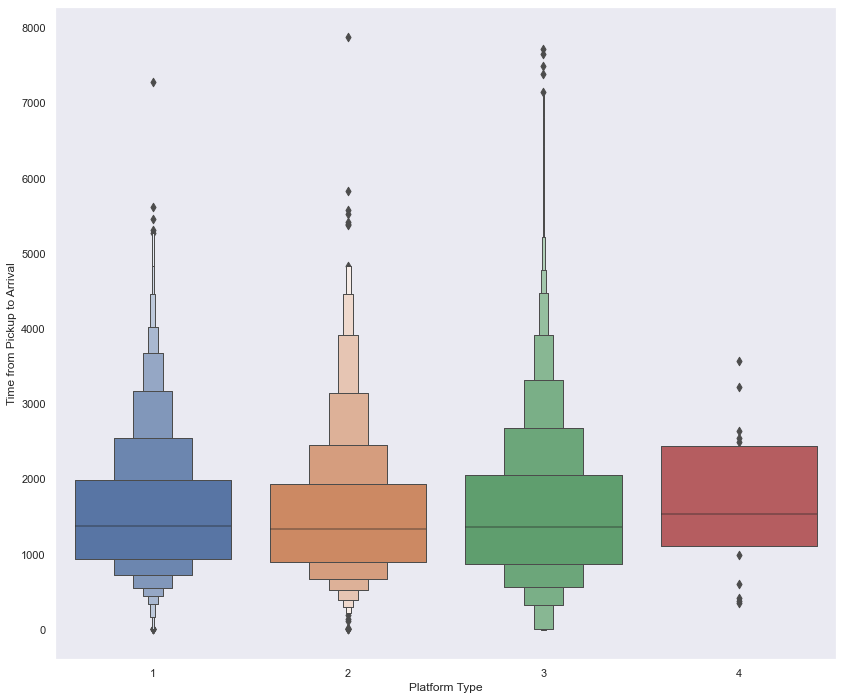

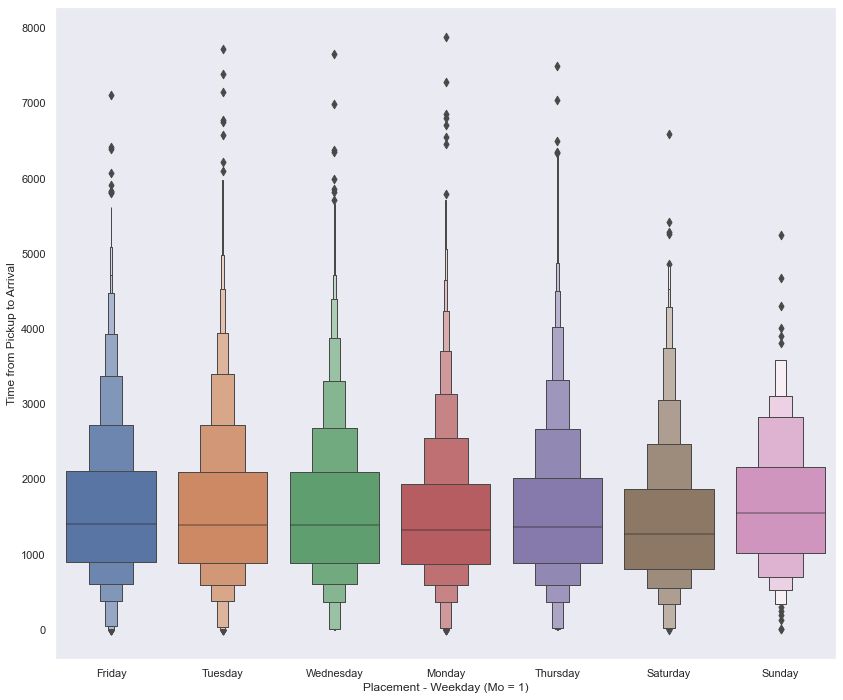

In [26]:
for col in  ['Platform Type', 'Placement - Weekday (Mo = 1)']:
    plt.figure(figsize = (14,12))
    h = sns.boxenplot(data = df_merged, x = col, y='Time from Pickup to Arrival')
    plt.xlabel(col)
    plt.ylabel('Time from Pickup to Arrival')
    plt.show()

In [27]:
listwe = list()
for i in df_merged['Placement - Weekday (Mo = 1)']:
    if i == 'Saturday' or i == 'Sunday':
        listwe.append(True)
    else:
        listwe.append(False)    

In [28]:
df_merged['Weekend'] = listwe

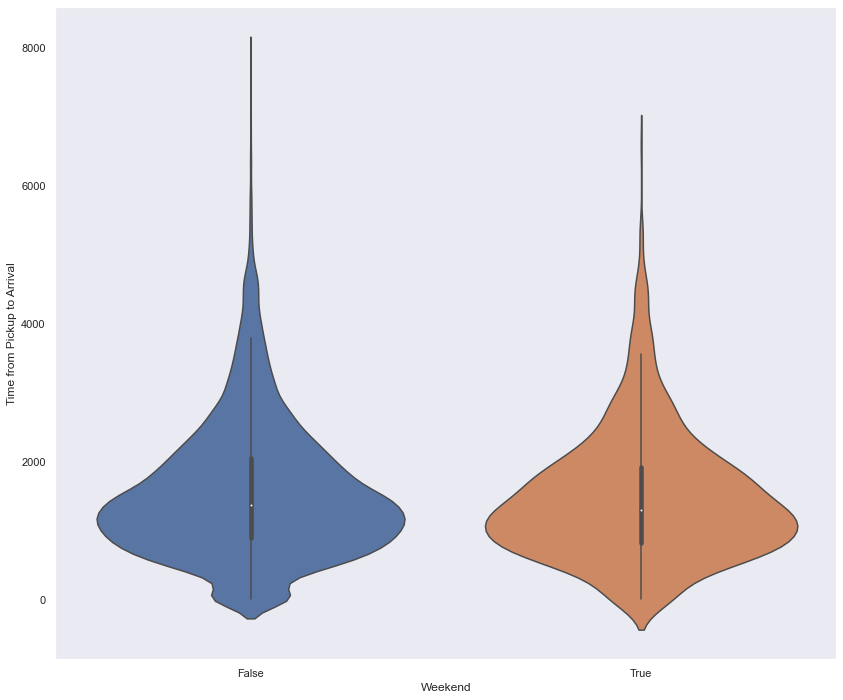

In [29]:
plt.figure(figsize = (14,12))
h = sns.violinplot(data = df_merged, x = 'Weekend', y='Time from Pickup to Arrival')
plt.xlabel('Weekend')
plt.ylabel('Time from Pickup to Arrival')
plt.show()

Il y'a en effet une différence assez légère.

#### Relation Target / Variables de temps

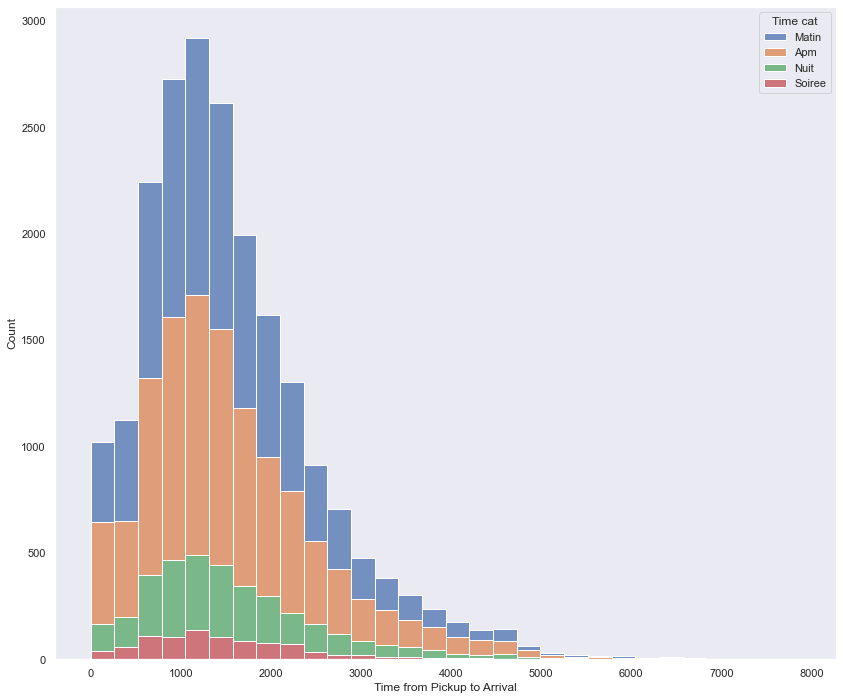

In [30]:
plt.figure(figsize = (14,12))
sns.histplot(data=df_merged, x="Time from Pickup to Arrival",bins = 30, hue = 'Time cat', multiple="stack")
plt.show()

Les variables de temps ne semblent pas avoir un impact significatif sur la target.

### Relation Variables / Variables

#### Variables quantitatives / quantitatives

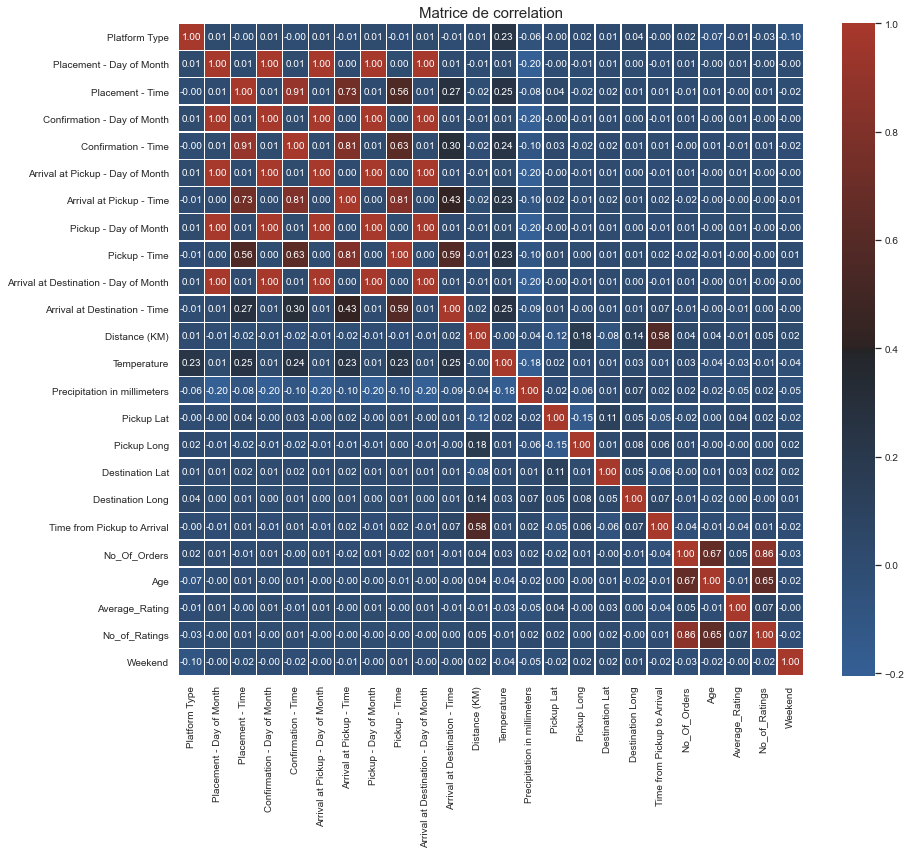

In [33]:
plt.figure(figsize=(14,12))
ax = sns.heatmap(df_merged.drop(['Confirmation - Day of Month', 'Confirmation - Time', ],axis = 1)corr(method='pearson'), 
    linewidths=.5,
    annot=True,
    annot_kws={"size": 10},
    fmt=".2f",
    cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="dark", as_cmap = True))
plt.title('Matrice de correlation', fontsize = 15)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

Cette matrice de corrélation nous indique plusieurs choses :
<ul>
    <li>Contrairement aux variables "Day of Month", les variables "Time" ne sont pas exactements identiques </li>
    <li>Le type de plateforme utilisé est faiblement corrélé (0.2) à la température</li>
    <li>La température est également faiblement corrélée aux variables "Time"</li>
    <li>Le niveau de précipitation est faiblement corrélé aux variables "Day of Month"</li>
    <li>La distance est fortement corrélée au temps de livraison (la target)</li>
    <li>L'age du livreur et son nombre de commandes réalisé sont fortements corrélés</li>
    <li>Le nombre de commandes réalisés et le nombre de notes est fortement corrélé</li>
</ul>

#### Variables qualitatives / qualitatives

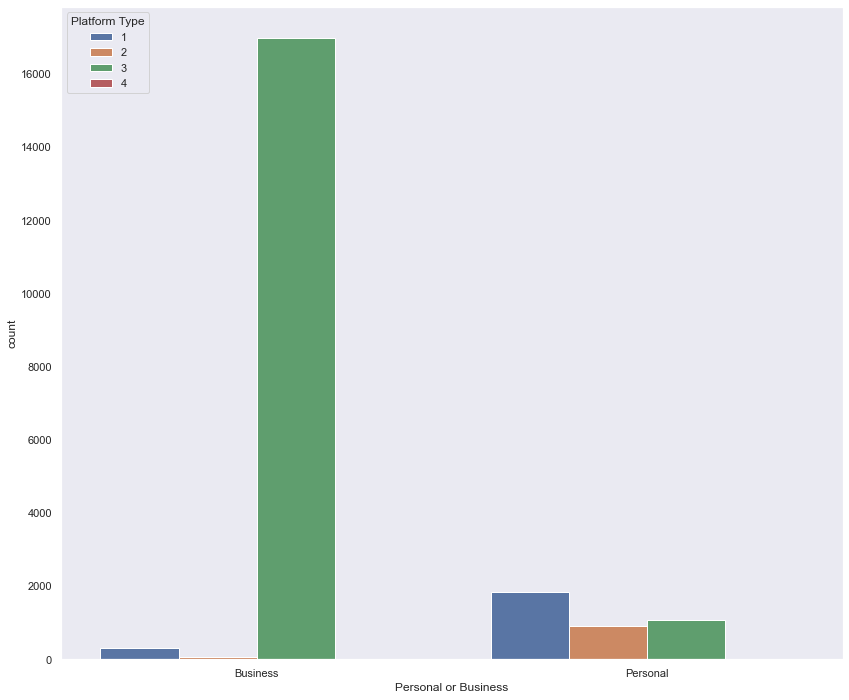

In [56]:
plt.figure(figsize = (14,12))
sns.countplot(x = df_merged['Personal or Business'], hue = df_merged['Platform Type'])
plt.show()

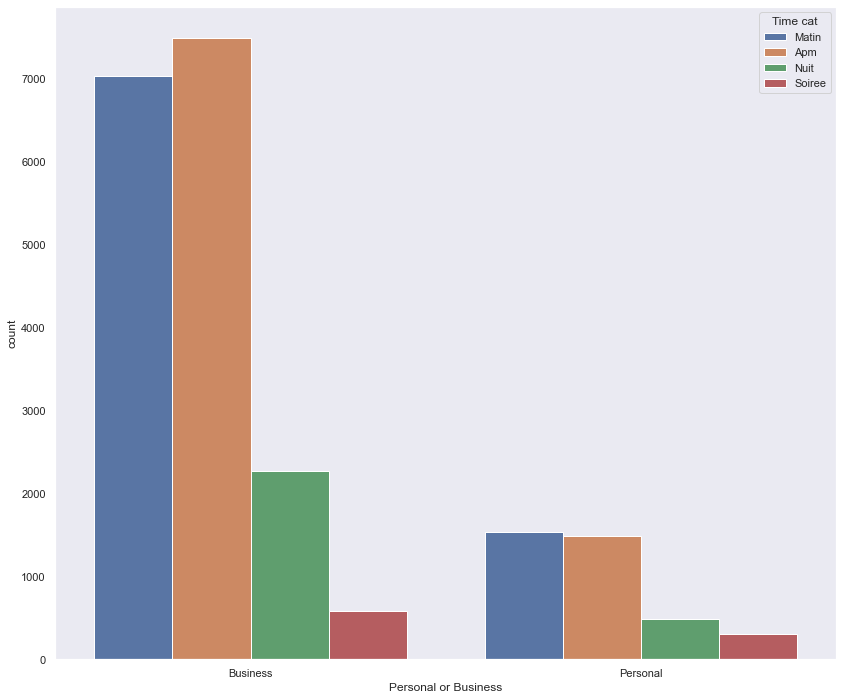

In [57]:
plt.figure(figsize = (14,12))
sns.countplot(x = df_merged['Personal or Business'], hue = df_merged['Time cat'])
plt.show()

<ul>
    <li> Les clients Buisness commandent majoritairement sur la plateforme 3 </li>
    <li> Gap plus important pour les buisness que personal entre journée et soirée. </li>
</ul>

#### Variables quantitatives / qualitatives

<Figure size 1008x864 with 0 Axes>

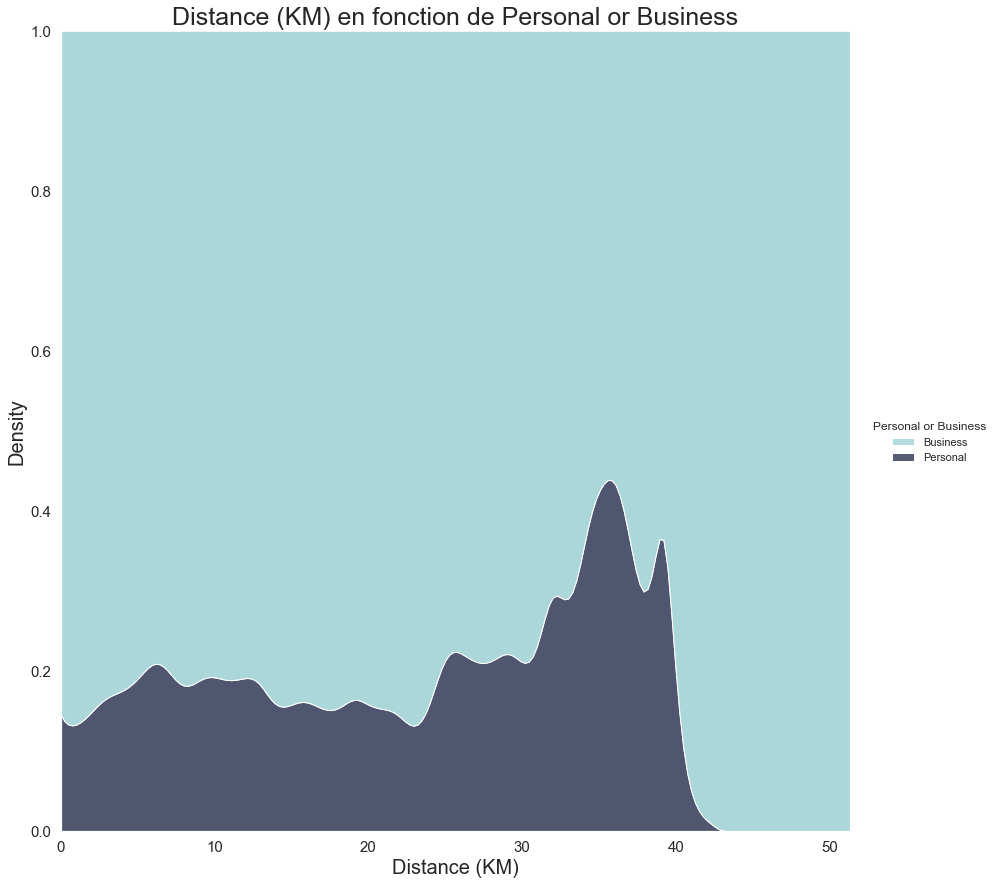

<Figure size 1008x864 with 0 Axes>

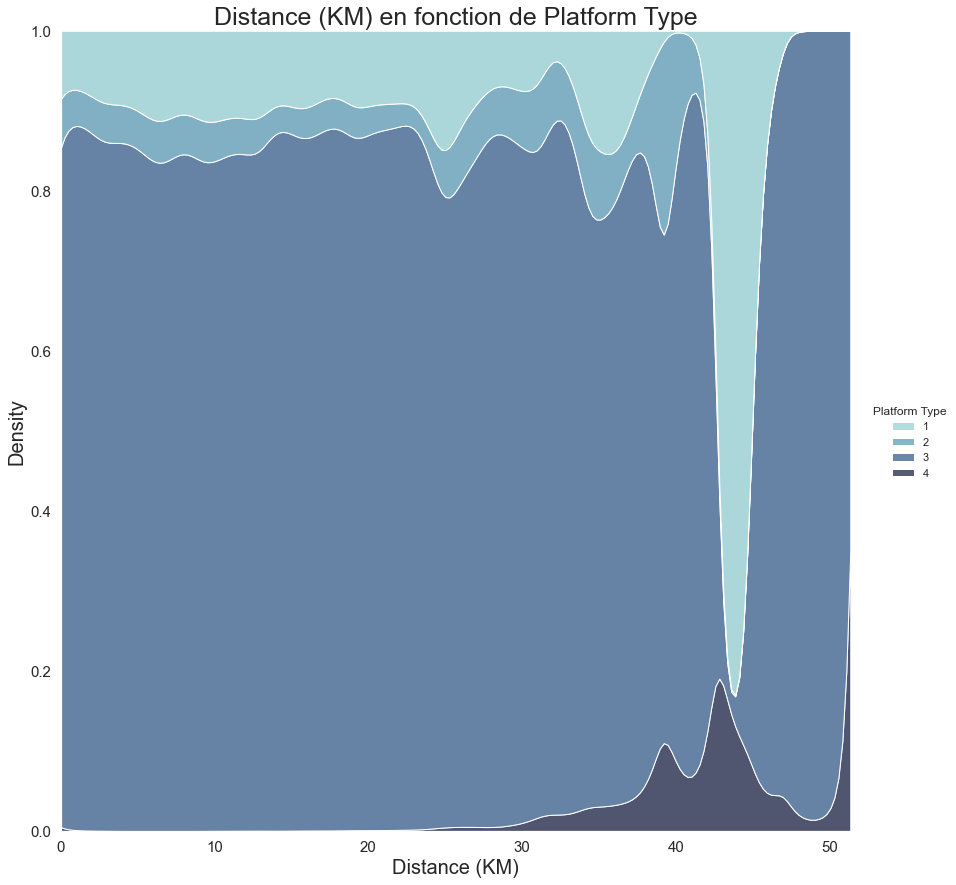

<Figure size 1008x864 with 0 Axes>

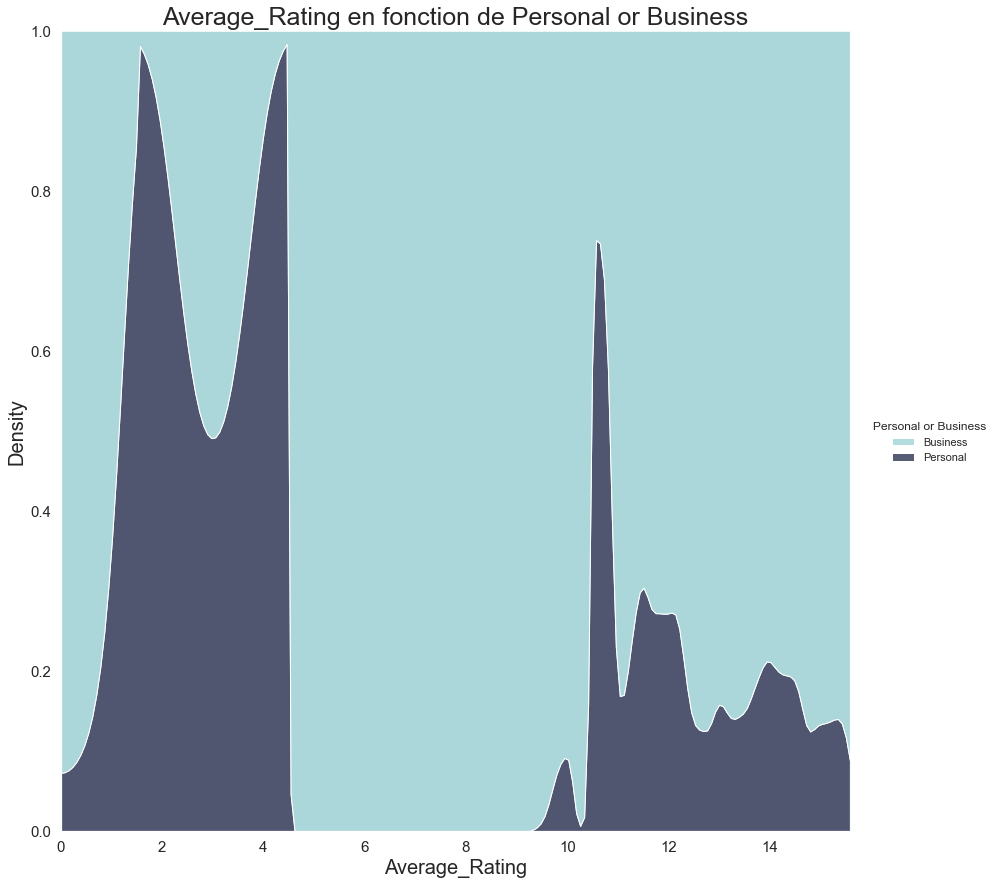

<Figure size 1008x864 with 0 Axes>

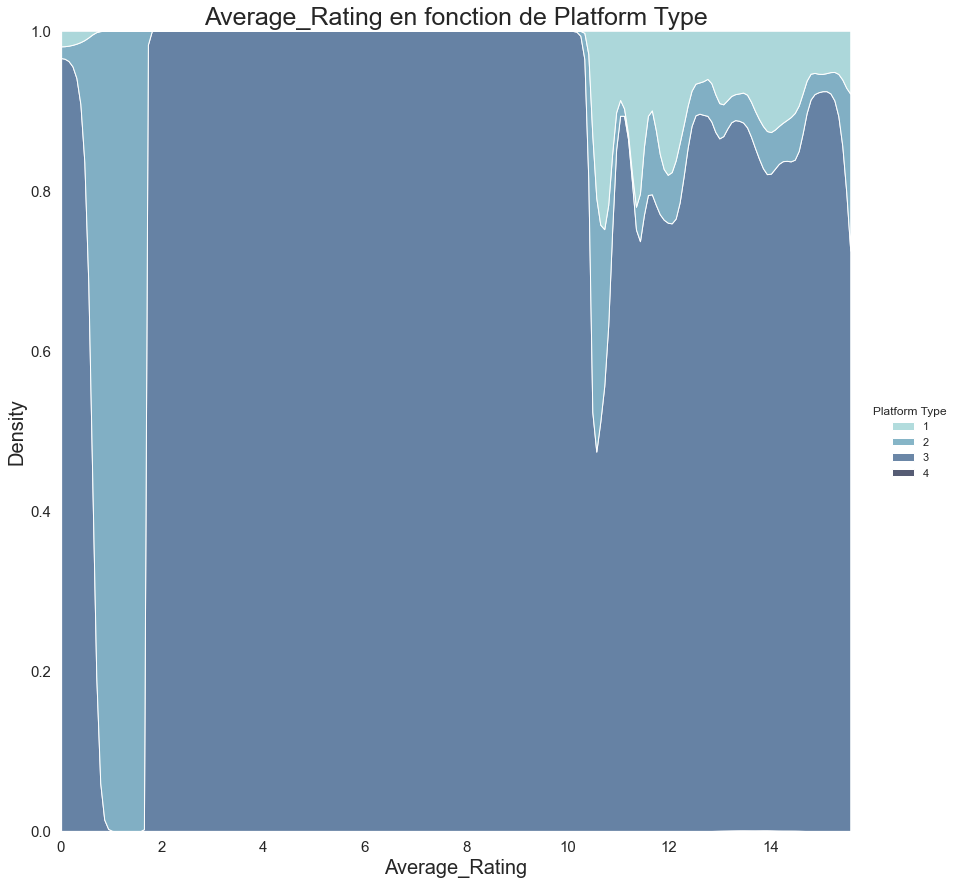

In [95]:
xlist = ['Distance (KM)', 'Average_Rating']
huelist = ['Personal or Business', 'Platform Type']
for variable in xlist:
    for elem in huelist:
        plt.figure(figsize = (14,12))
        sns.displot(
        data=df_merged,
            x=variable, hue=df_merged[elem],
            kind="kde", height=12,
            multiple="fill", clip=(0, None),
            palette="ch:rot=-.25, hue=1, light=.75")
        plt.title(str(variable)+' en fonction de '+str(elem), fontsize = 25)
        plt.xlabel(variable, fontsize = 20)
        plt.ylabel('Density', fontsize = 20)
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.show()

<ul>
    <li> Les trajets pour les clients "Personal" ne dépassent pas les 40 km contrairement aux "Buisness" </li>
    <li> Grande majorité des commandes se font sur la plateforme 3, mais grand nombre de commandes à 45 km environ se font sur la plateforme 1 </li>
    <li> Les particuliers semblent noté ou mal ou bien, il n'y pas d'entre deux. Ou la densité écrasé face au nombre de Buisness</li>
    <li> Les commandes issues de la platform 2 semblent très mal notées </li>
    <li> (non affiché) : Les particuliers semblent commander beaucoup quand il fait froid </li>
</ul>